# 03 — Visuals for the Report (Bellabeat)

Objective:
Create a small set of clean, business-focused visuals that support the key findings from Notebook 02:

1) User activity segmentation  
2) Sedentary time vs activity level  
3) Time-of-day activity patterns  
4) Sleep vs activity relationship  

These visuals are designed for stakeholder communication and portfolio presentation.




In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [31]:
# Resolve project root robustly (works in Codespaces + local)
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_dir = project_root / "data_cleaned"
reports_dir = project_root / "reports"
reports_dir.mkdir(exist_ok=True)

def savefig(name: str):
    """Save current matplotlib figure into /reports with consistent settings."""
    plt.savefig(reports_dir / name, dpi=300, bbox_inches="tight")

print("Project root:", project_root)
print("Data dir:", data_dir)
print("Reports dir:", reports_dir)


Project root: /workspaces/bellabeat-smart-device-usage-analysis
Data dir: /workspaces/bellabeat-smart-device-usage-analysis/data_cleaned
Reports dir: /workspaces/bellabeat-smart-device-usage-analysis/reports


In [32]:
daily = pd.read_csv(data_dir / "daily_activity_clean.csv", parse_dates=["activity_date"])
sleep = pd.read_csv(data_dir / "sleep_day_clean.csv", parse_dates=["sleep_day"])
h_steps = pd.read_csv(data_dir / "hourly_steps_clean.csv", parse_dates=["activity_hour"])

daily.shape, sleep.shape, h_steps.shape


((940, 15), (410, 5), (22099, 3))

In [33]:
user_daily = (
    daily.groupby("id", as_index=False)
    .agg(
        avg_steps=("totalsteps", "mean"),
        avg_sedentary_min=("sedentaryminutes", "mean"),
        avg_very_active_min=("veryactiveminutes", "mean"),
    )
)

def steps_segment(x):
    if x < 5000:
        return "Sedentary (<5k)"
    elif x < 7500:
        return "Low active (5k–7.5k)"
    elif x < 10000:
        return "Somewhat active (7.5k–10k)"
    elif x < 12500:
        return "Active (10k–12.5k)"
    else:
        return "Highly active (12.5k+)"

user_daily["steps_segment"] = user_daily["avg_steps"].apply(steps_segment)

segment_order = [
    "Sedentary (<5k)",
    "Low active (5k–7.5k)",
    "Somewhat active (7.5k–10k)",
    "Active (10k–12.5k)",
    "Highly active (12.5k+)"
]

user_daily["steps_segment"] = pd.Categorical(
    user_daily["steps_segment"],
    categories=segment_order,
    ordered=True
)

user_daily.head()


,id,avg_steps,avg_sedentary_min,avg_very_active_min,steps_segment
0,1503960366,12116.741935,848.161290,38.709677,Active (10k–12.5k)
1,1624580081,5743.903226,1257.741935,8.677419,Low active (5k–7.5k)
2,1644430081,7282.966667,1161.866667,9.566667,Low active (5k–7.5k)
3,1844505072,2580.064516,1206.612903,0.129032,Sedentary (<5k)
4,1927972279,916.129032,1317.419355,1.322581,Sedentary (<5k)


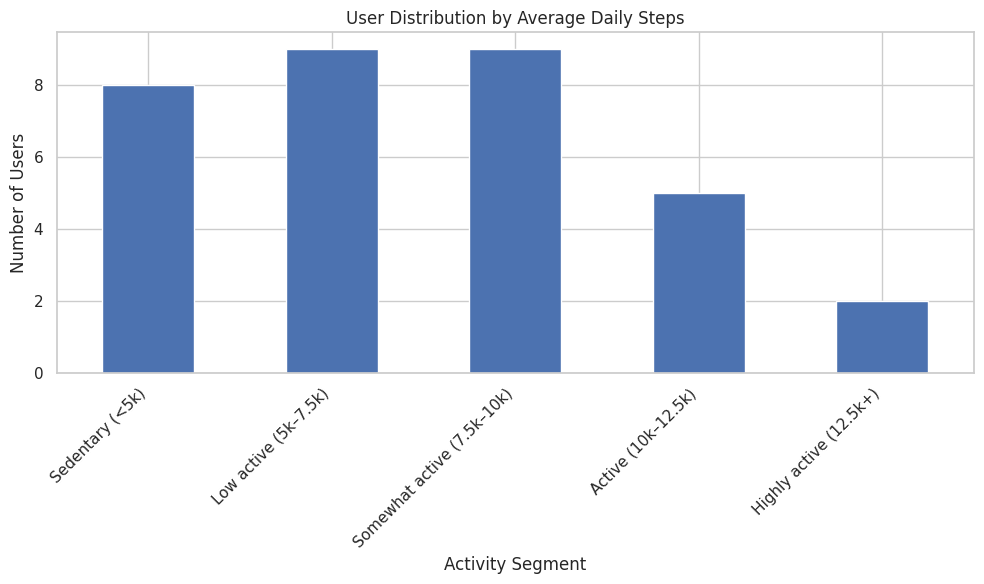

In [34]:
segment_counts = user_daily["steps_segment"].value_counts().sort_index()

ax = segment_counts.plot(kind="bar")
plt.title("User Distribution by Average Daily Steps")
plt.xlabel("Activity Segment")
plt.ylabel("Number of Users")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

savefig("01_steps_segment_distribution.png")
plt.show()


**So what:** Most users cluster in the lower activity segments, so Bellabeat should prioritise onboarding and messaging that supports habit-building for everyday users rather than performance fitness tracking.



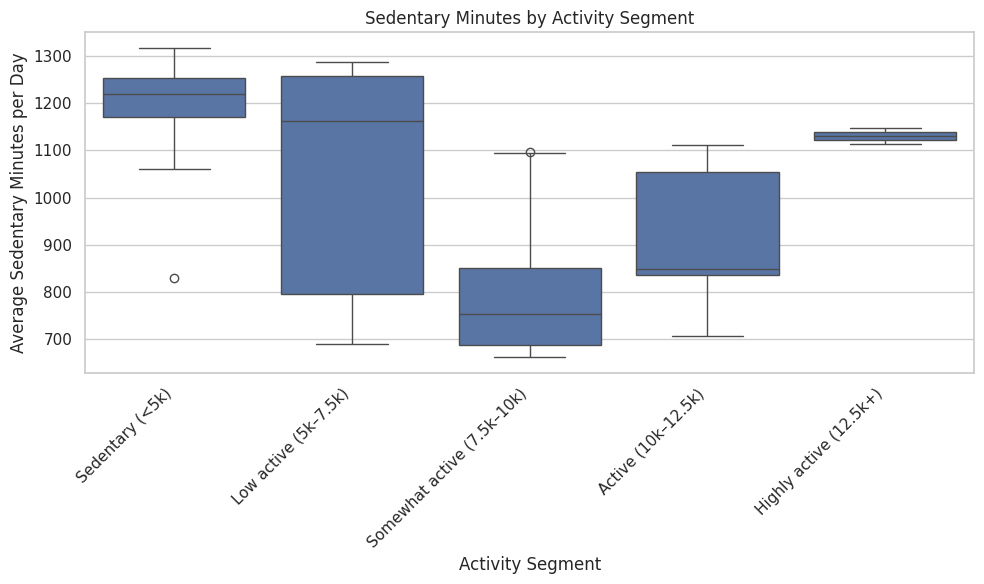

In [35]:
sns.boxplot(
    data=user_daily,
    x="steps_segment",
    y="avg_sedentary_min",
    order=segment_order
)
plt.title("Sedentary Minutes by Activity Segment")
plt.xlabel("Activity Segment")
plt.ylabel("Average Sedentary Minutes per Day")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

savefig("02_sedentary_by_segment.png")
plt.show()




**So what:** Sedentary time remains high even as step counts rise. This supports product opportunities around micro-interventions that reduce prolonged sitting (gentle nudges, posture/mobility prompts, short movement routines).


In [36]:
candidate_cols = ["steptotal", "steps", "totalsteps", "stepstotal"]
steps_col = next((c for c in candidate_cols if c in h_steps.columns), None)

if steps_col is None:
    raise ValueError(f"No steps column found. Available columns: {list(h_steps.columns)}")

steps_col


'steptotal'

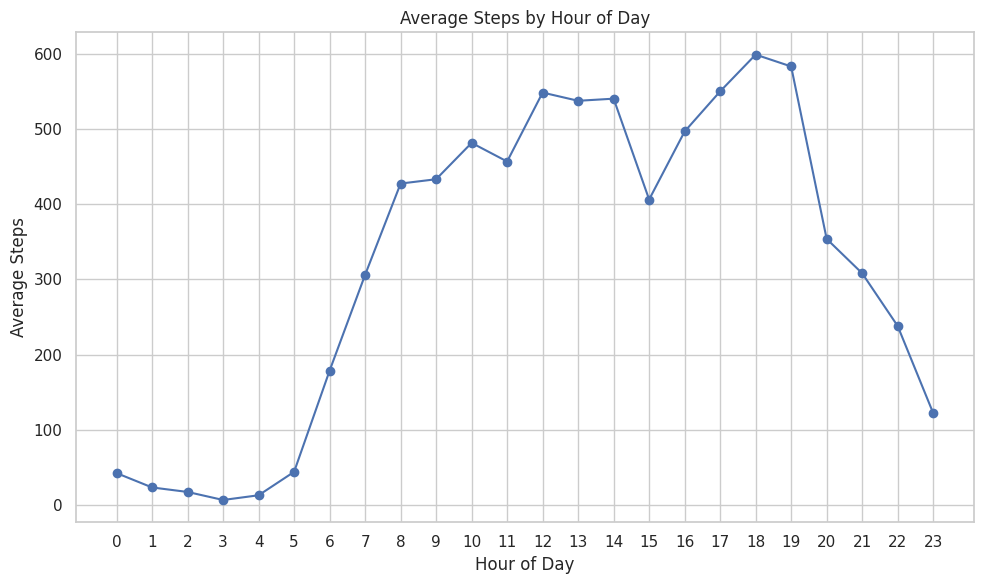

In [37]:
h_steps["hour"] = h_steps["activity_hour"].dt.hour

hourly_profile = (
    h_steps.groupby("hour", as_index=False)
    .agg(avg_steps=(steps_col, "mean"))
)

plt.plot(hourly_profile["hour"], hourly_profile["avg_steps"], marker="o")
plt.title("Average Steps by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Steps")
plt.xticks(range(0, 24))
plt.tight_layout()

savefig("03_avg_steps_by_hour.png")
plt.show()


**So what:** Activity peaks during daytime hours and drops in the evening. Bellabeat can time prompts for higher engagement during daytime and shift evening prompts toward wind-down routines rather than step goals.


In [38]:
sleep_merge = sleep.copy()
sleep_merge["activity_date"] = pd.to_datetime(sleep_merge["sleep_day"].dt.date)

daily_merge = daily.copy()
daily_merge["activity_date"] = pd.to_datetime(daily_merge["activity_date"].dt.date)

merged = daily_merge.merge(
    sleep_merge,
    on=["id", "activity_date"],
    how="inner"
)

merged.shape


(410, 19)

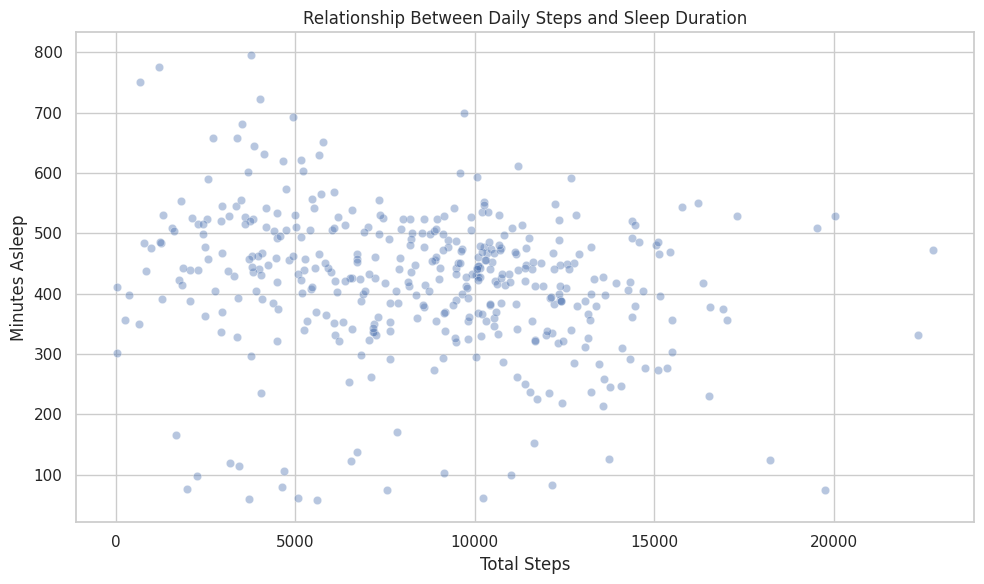

['01_steps_segment_distribution.png',
 '02_sedentary_by_segment.png',
 '03_avg_steps_by_hour.png',
 '04_steps_vs_sleep.png']

In [40]:
if "totalminutesasleep" in merged.columns:
    sns.scatterplot(
        data=merged,
        x="totalsteps",
        y="totalminutesasleep",
        alpha=0.4
    )
    plt.title("Relationship Between Daily Steps and Sleep Duration")
    plt.xlabel("Total Steps")
    plt.ylabel("Minutes Asleep")
    plt.tight_layout()

    savefig("04_steps_vs_sleep.png")
    plt.show()
else:
    print("Column 'totalminutesasleep' not found in merged sleep data.")
sorted([p.name for p in reports_dir.glob("*.png")])


**So what:** The relationship between steps and sleep is positive but weak. This supports a holistic wellness approach (habits + routines) rather than assuming more activity automatically fixes sleep outcomes.



## Visual Summary

These visuals support four core conclusions:

- Most users are low to moderately active (product should prioritise habit formation).
- Sedentary time is prevalent across all segments (opportunity for micro-movement prompts).
- Activity follows predictable daily rhythms (notification timing should match behaviour).
- Steps and sleep are related but not strongly (position as holistic wellness, not single-metric optimisation).

All charts are saved to the `reports/` folder for easy inclusion in the README or a stakeholder deck.
